# UNet Model on CIFAR-10 Dataset
*Author: Preetham Ramesh*

## Objective
The goal of this notebook is to apply the UNet pretrained model on the CIFAR-10 dataset.

## Resources
* **About UNet**
The UNet model is a convolutional neural network commonly used for image segmentation tasks. Its architecture consists of a contracting path to capture context and a symmetric expanding path for precise localization. This U-shaped network structure enables the model to efficiently learn and segment images by combining high-resolution features from the contracting path with localization information from the expanding path.

* **About CIFAR-10**
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. http://www.cs.toronto.edu/~kriz/cifar.html

## 1.) Import packages and notebook settings

In [51]:
from collections import OrderedDict
import os
import random
import numpy as np
import torch
import torch.nn as nn

In [52]:
device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda:0' if torch.cuda.is_available() else 'cpu'))
print(device)

cuda:0


**Seed Setting**:
Different sources of randomness contribute to the result of a neural network model. Nevertheless, a good neural network model should not depend on the eed but the data, architecture, and hyperparameters used. We introduce a seed value for the sake of reproducibility of our results. We set the `seed_value` to `42` for the following sources of randomness:
1. within the environment
2. within Python
3. within some packages like numpy and torch
4. and anywhere else where randomness is introduced like within architectures (some dropout layers introduce randomness)


In [53]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` and `torch` pseudo-random generator at a fixed value
np.random.seed(seed_value)
torch.manual_seed(seed_value)

**Variable setting**

In [54]:
BATCH_SIZE = 64
NUM_EPOCHS = 100
LR = 0.01

**Model**

In [55]:
import torch.nn as nn

class UNetCIFAR(nn.Module):

    def __init__(self, in_channels=3, out_channels=10, init_features=32):
        super(UNetCIFAR, self).__init__()

        features = init_features
        
        # Encoder
        self.encoder1 = UNetCIFAR._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNetCIFAR._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = UNetCIFAR._block(features * 2, features * 4, name="bottleneck")
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder1 = UNetCIFAR._block(features * 4, features * 2, name="dec1")
        self.upconv2 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder2 = UNetCIFAR._block(features * 2, features, name="dec2")
        
        # Output Convolution
        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        bottleneck = self.bottleneck(self.pool2(enc2))

        dec1 = self.upconv1(bottleneck)
        dec1 = torch.cat((dec1, enc2), dim=1)
        dec1 = self.decoder1(dec1)
        dec2 = self.upconv2(dec1)
        dec2 = torch.cat((dec2, enc1), dim=1)
        dec2 = self.decoder2(dec2)
        return self.conv(dec2)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )


**Transform and Load Data**

In [56]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Define transformations for the dataset (optional but recommended)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image data
])

# Download and load the CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_size = 7500

train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoaders to handle batches and shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


**Training**

In [57]:
import timeit
import torch.optim as optim

model = UNetCIFAR().to(device)  
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

summary = {
    'train_losses_history': [],
    'train_corrects_history': [],
    'val_losses_history': [],
    'val_corrects_history': [],
    'epoch_times_history': []
}

# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()

    running_loss = 0.0
    train_loss = 0.0
    train_corrects = 0.0
    val_corrects = 0.0
    start_time = timeit.default_timer()

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs.shape)

        labels = labels.view(-1, 1, 1, 1)
        labels = labels.repeat(1, 10, 32, 32)

        loss = criterion(outputs.float(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_preds = outputs.round()
        train_corrects += torch.sum(train_preds == labels).item()


        if i % 100 == 99:
            train_loss = round(running_loss / 100, 4)
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {train_loss}")
            running_loss = 0.0
    
    train_epoch_acc = train_corrects / (len(train_loader.dataset) * 10 * 32 * 32)  # Calculate accuracy

    model.eval() 
    val_loss = 0.0
    val_corrects = 0.0

    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device).float()

            val_outputs = model(val_inputs)
            val_labels = val_labels.view(-1, 1, 1, 1).repeat(1, 10, 32, 32)

            loss = criterion(val_outputs.float(), val_labels)
            val_loss += loss.item()

            # Calculate accuracy
            val_preds = val_outputs.round()  # Assuming rounding for binary classification
            val_corrects += torch.sum(val_preds == val_labels).item()

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_acc = val_corrects / (len(val_loader.dataset) * 10 * 32 * 32)  # Calculate accuracy

    summary['epoch_times_history'].append(round(timeit.default_timer() - start_time, 4))
    summary['val_losses_history'].append(val_epoch_loss)
    summary['val_corrects_history'].append(val_epoch_acc)
    summary['train_corrects_history'].append(train_epoch_acc)
    summary['train_losses_history'].append(train_loss)


Epoch: 1, Batch: 100, Loss: 10.0831
Epoch: 1, Batch: 200, Loss: 8.143
Epoch: 1, Batch: 300, Loss: 7.9887
Epoch: 1, Batch: 400, Loss: 7.8658
Epoch: 1, Batch: 500, Loss: 7.782
Epoch: 1, Batch: 600, Loss: 7.8986
Epoch: 2, Batch: 100, Loss: 7.8075
Epoch: 2, Batch: 200, Loss: 7.51
Epoch: 2, Batch: 300, Loss: 7.3911
Epoch: 2, Batch: 400, Loss: 7.1384
Epoch: 2, Batch: 500, Loss: 6.7888
Epoch: 2, Batch: 600, Loss: 6.8836
Epoch: 3, Batch: 100, Loss: 6.353
Epoch: 3, Batch: 200, Loss: 6.3054
Epoch: 3, Batch: 300, Loss: 6.163
Epoch: 3, Batch: 400, Loss: 5.6834
Epoch: 3, Batch: 500, Loss: 5.5389
Epoch: 3, Batch: 600, Loss: 5.5652
Epoch: 4, Batch: 100, Loss: 5.2317
Epoch: 4, Batch: 200, Loss: 4.8499
Epoch: 4, Batch: 300, Loss: 5.0327
Epoch: 4, Batch: 400, Loss: 4.7604
Epoch: 4, Batch: 500, Loss: 4.6795
Epoch: 4, Batch: 600, Loss: 4.765
Epoch: 5, Batch: 100, Loss: 4.4748
Epoch: 5, Batch: 200, Loss: 4.3109
Epoch: 5, Batch: 300, Loss: 4.4316
Epoch: 5, Batch: 400, Loss: 4.2979
Epoch: 5, Batch: 500, Loss

In [58]:
summary

{'train_losses_history': [7.8986,
  6.8836,
  5.5652,
  4.765,
  4.2888,
  3.8913,
  3.6321,
  3.4399,
  3.2348,
  3.1844,
  2.8294,
  2.7277,
  2.4619,
  2.3677,
  2.2338,
  2.0766,
  1.9426,
  1.8466,
  1.711,
  1.6263,
  1.609,
  1.5754,
  1.4029,
  1.3557,
  1.296,
  1.2457,
  1.2147,
  1.1304,
  1.1433,
  1.1032,
  0.9882,
  0.9294,
  0.937,
  0.9002,
  0.9203,
  0.8583,
  0.8821,
  0.7707,
  0.7544,
  0.7945,
  0.7344,
  0.6629,
  0.688,
  0.6583,
  0.6818,
  0.6309,
  0.6305,
  0.5997,
  0.6337,
  0.5802,
  0.6288,
  0.58,
  0.5213,
  0.5338,
  0.511,
  0.5419,
  0.5515,
  0.4838,
  0.4538,
  0.4714,
  0.4851,
  0.5804,
  0.5225,
  0.4656,
  0.5043,
  0.4581,
  0.4098,
  0.3906,
  0.4348,
  0.4002,
  0.4513,
  0.48,
  0.3915,
  0.39,
  0.3733,
  0.3699,
  0.3733,
  0.3705,
  0.3981,
  0.3923,
  0.3432,
  0.4498,
  0.387,
  0.306,
  0.3367,
  0.3361,
  0.3109,
  0.3425,
  0.3273,
  0.3204,
  0.323,
  0.312,
  0.3344,
  0.2856,
  0.2769,
  0.2726,
  0.3638,
  0.2921,
  0.2759,
  0

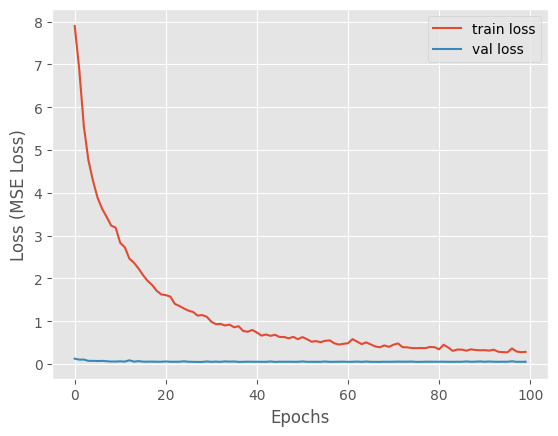

In [59]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.plot(summary['train_losses_history'], label="train loss")
plt.plot(summary['val_losses_history'], label="val loss")
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE Loss)')
plt.legend()
plt.show()


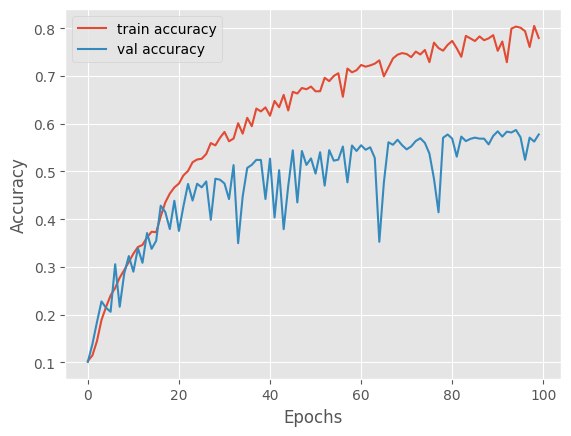

In [60]:
plt.style.use("ggplot")
plt.plot(summary['train_corrects_history'], label="train accuracy")
plt.plot(summary['val_corrects_history'], label="val accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


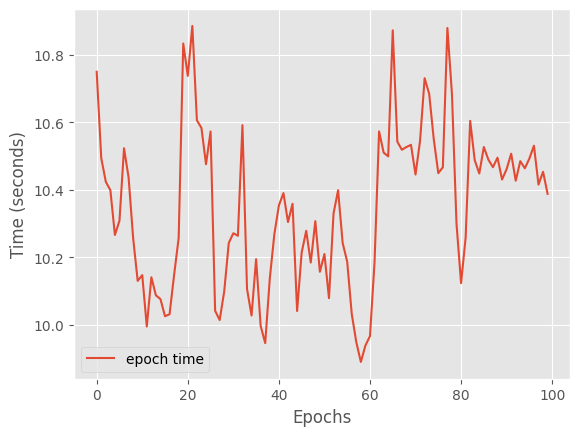

In [61]:
plt.style.use("ggplot")
plt.plot(summary['epoch_times_history'], label="epoch time")
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()